In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt

import utils.gpx as gp
import utils.graph as gr
import utils.postman as po
import utils.vis as vis


from postman_problems.solver import rpp
from postman_problems.stats import calculate_postman_solution_stats

In [2]:
G = ox.graph_from_place("Pacific Spirit Regional Park", network_type="all", retain_all=True, simplify=True)
ox.graph_to_gdfs(G, nodes=False).explore()

In [3]:
nodes = pd.read_csv("data/nodes.csv")
edges = pd.read_csv("data/edges.csv")
print(nodes.head())
print(edges.head())

  id         Y          X
0  A  49.24925 -123.21754
1  B  49.24677 -123.22262
2  C  49.24915 -123.22355
3  D  49.24941 -123.22053
4  E  49.24968 -123.22376
  node1 node2  distance  elevation  required  entrance  road_crossing
0     A     B       470          6         1       NaN            NaN
1     A     D       220          0         1       NaN            NaN
2     A     F        45          0         1       NaN            NaN
3     B     C       274         11         1       NaN            NaN
4     B     L       276          3         1       NaN            NaN


In [4]:
print(f"Total Nodes: {len(nodes)}")
print(f"Total Edges: {len(edges)}")
print(f"Required Edges: {len(edges.query('required == 1'))}")
print(f"Total Distance: {edges['distance'].sum() / 1000}km")
print(f"Required Distance: {edges.query('required == 1')['distance'].sum() / 1000}km")

Total Nodes: 146
Total Edges: 221
Required Edges: 191
Total Distance: 55.45km
Required Distance: 47.8km


In [5]:
#Creating the optimal route
EDGELIST = 'edges.csv'
START_NODE = 'CE'
optimal_circuit, ultra_graph = rpp(EDGELIST, START_NODE)

for k, v in calculate_postman_solution_stats(optimal_circuit).items():
    print(f"{k} : {v}")

c:\users\seang\onedrive\documents\projects\ultra-optimization\postman_problems\postman_problems\graph.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  g.add_edge(row[1][0], row[1][1], **edge_attr_dict)


distance_walked : 58871
distance_doublebacked : 11071
distance_walked_once : 47800
distance_walked_optional : 1898
distance_walked_required : 56973
edges_walked : 257
edges_doublebacked : 66
edges_walked_once : 191
edges_walked_optional : 9
edges_walked_required : 248


In [6]:
#Comparison with existing route 
ultra_gpx_points = gp.load_gpx_points("data/Pacific Spirit Ultramathon Version 4.gpx")
nodes_gdf = po.nodelist_to_gpd(nodes)
ultra_graph = po.construct_graph_for_rpp(nodes_gdf, edges)

In [7]:
actual_route = gp.gpx_points_to_osmnx_route(ultra_gpx_points, ultra_graph, threshold_dist=10)
actual_circuit = po.osmnx_route_to_rpp_circuit(actual_route[0], ultra_graph)

No direct route between nodes EH and EE, adding path [['EH', 'EG', 'EE']]
No direct route between nodes EE and DQ, adding path [['EE', 'EG', 'DQ']]
No direct route between nodes DQ and DL, adding path [['DQ', 'DP', 'DL']]
No direct route between nodes CY and CT, adding path [['CY', 'CU', 'CT']]
No direct route between nodes BP and BR, adding path [['BP', 'BQ', 'BR']]
No direct route between nodes BS and BT, adding path [['BS', 'BR', 'BT']]
No direct route between nodes BR and I, adding path [['BR', 'BQ', 'I']]
No direct route between nodes AT and AR, adding path [['AT', 'AS', 'AR']]
No direct route between nodes AD and AA, adding path [['AD', 'AC', 'AB', 'AA']]
No direct route between nodes BE and CH, adding path [['BE', 'CG', 'CH']]
No direct route between nodes CN and CP, adding path [['CN', 'CF', 'CP']]
No direct route between nodes CI and CG, adding path [['CI', 'CH', 'CG']]


In [8]:
actual_stats = calculate_postman_solution_stats(actual_circuit)
optimal_stats = calculate_postman_solution_stats(optimal_circuit)

for k in actual_stats.keys():
    diff  = actual_stats[k] - optimal_stats[k]
    print(str(k) + ' : ' + str(actual_stats[k]) + " | Difference of " + str(diff) + " with optimal route")

distance_walked : 62718 | Difference of 3847 with optimal route
distance_doublebacked : 16753 | Difference of 5682 with optimal route
distance_walked_once : 45965 | Difference of -1835 with optimal route
distance_walked_optional : 3811 | Difference of 1913 with optimal route
distance_walked_required : 58907 | Difference of 1934 with optimal route
edges_walked : 280 | Difference of 23 with optimal route
edges_doublebacked : 106 | Difference of 40 with optimal route
edges_walked_once : 174 | Difference of -17 with optimal route
edges_walked_optional : 18 | Difference of 9 with optimal route
edges_walked_required : 262 | Difference of 14 with optimal route


In [9]:
#Sanity check optimal solution
covered, missing = po.check_circuit_covers_all_required(optimal_circuit, ultra_graph)
print(f"All required edges covered in optimal circuit: {covered}")
print(f"Missing edges from optimal circuit {missing}")

#The actual circuit is missing some edges marked as required, but these do not add up to significant distance
#or were only 'missed' when constructing the path from the gpx route
covered, missing = po.check_circuit_covers_all_required(actual_circuit, ultra_graph)
print(f"All required edges covered in actual circuit: {covered}")
print(f"Missing edges from actual circuit {missing}")

All required edges covered in optimal circuit: True
Missing edges from optimal circuit []
All required edges covered in actual circuit: False
Missing edges from actual circuit [('P', 'Q'), ('Q', 'P'), ('AF', 'AG'), ('AG', 'AF'), ('AH', 'AI'), ('AI', 'AH'), ('AM', 'AR'), ('AT', 'AU'), ('AR', 'AM'), ('AU', 'AT'), ('BT', 'BU'), ('BU', 'BT'), ('BU', 'BW'), ('BW', 'BU'), ('BZ', 'BY'), ('BY', 'BZ')]


In [10]:
ox.graph_to_gdfs(ultra_graph, nodes=False).explore()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>
INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


<Figure size 2000x1000 with 0 Axes>

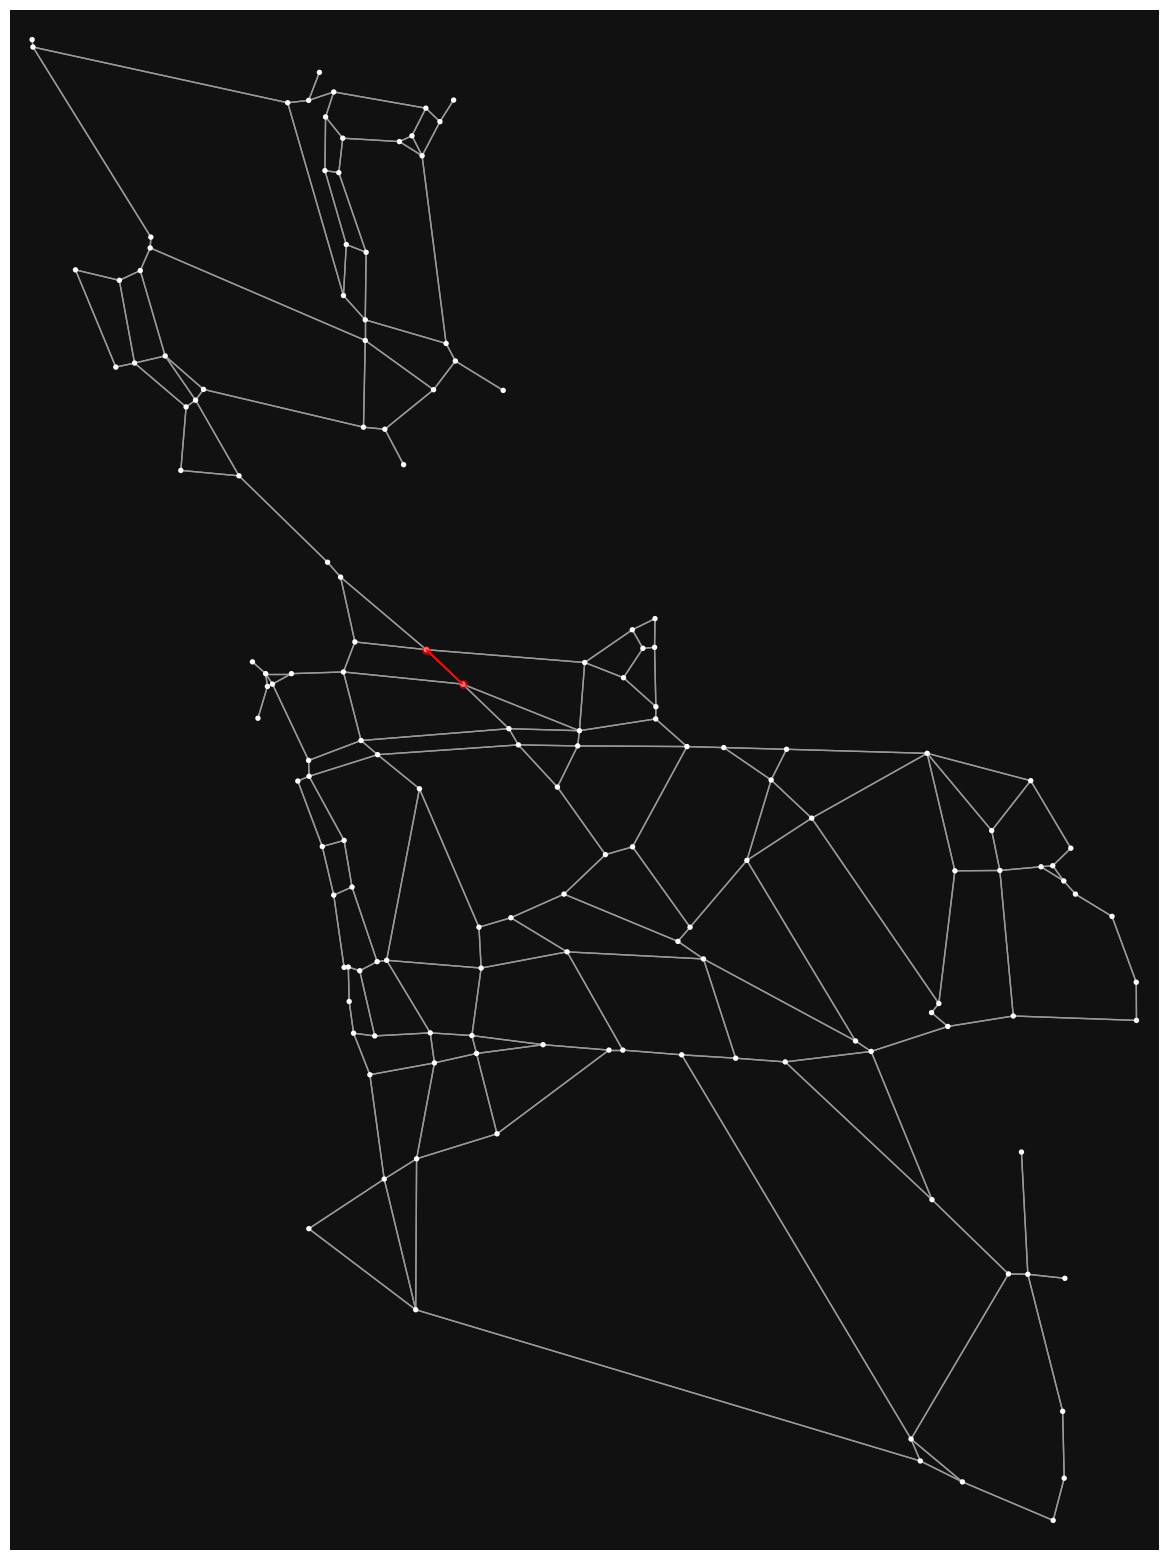

<Figure size 2000x1000 with 0 Axes>

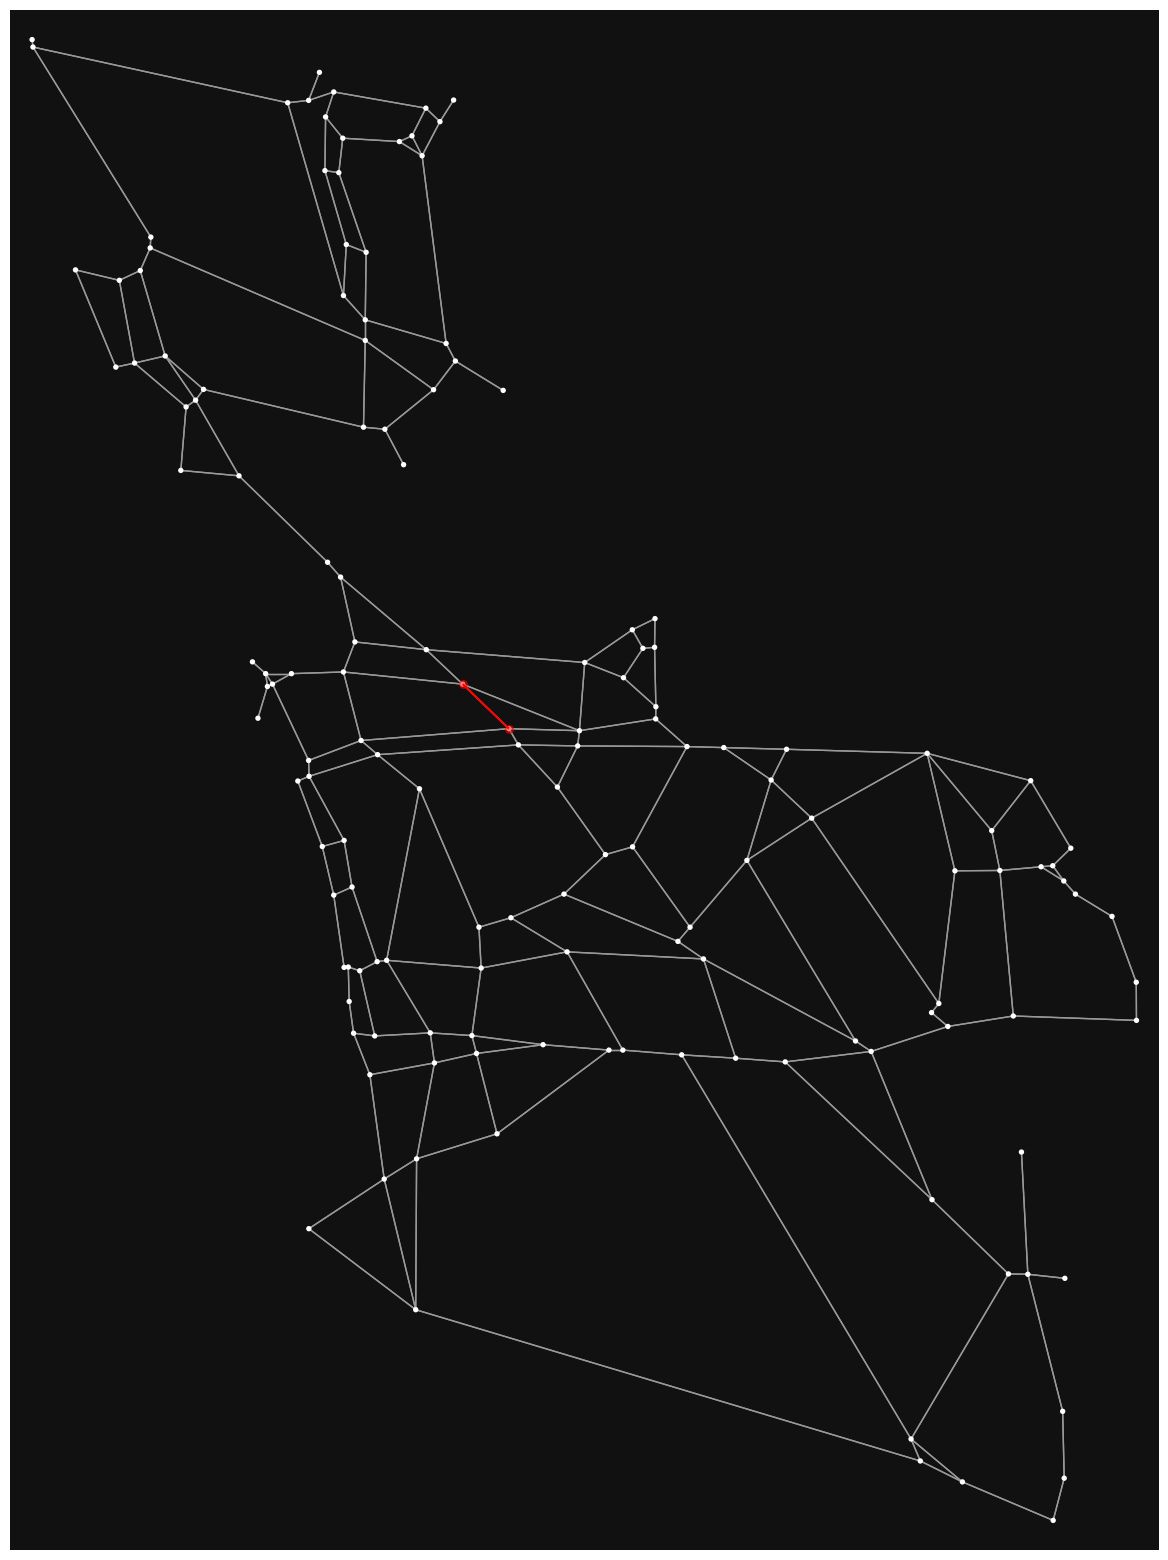

In [11]:
import utils.vis as vis

actual_route_anim = vis.animate_circuit(ultra_graph, actual_circuit, animation_func=vis.animate_segments_circuit)
actual_route_anim.save("actual_route.gif", writer="pillow")
optimal_route_anim = vis.animate_circuit(ultra_graph, optimal_circuit, animation_func=vis.animate_segments_circuit)
optimal_route_anim.save("optimal_route.gif", writer="pillow")